# Host-guest complex setup and simulation using SMIRNOFF

This notebook takes a SMILES string for a guest and a 3D structure for a host, and generates an initial structure of the complex using docking. It then proceeds to solvate, parameterize the system, and then minimize and do a short simulation with OpenMM.

Please note this is intended for educational purposes and comprises a worked example, not a polished tool. The usual disclaimers apply -- don't take anything here as advice on how you should set up these types of systems; this is just an example of setting up a nontrivial system with SMIRNOFF.

*Author - David Mobley (UC Irvine)*

## Prerequisites

Before beginning, you're going to need a license to the OpenEye toolkits (free for academics), and have these installed and working, ideally in your anaconda Python distribution. Then you'll also need the `openforcefield` toolkits installed, which you can do via `conda install -c omnia openforcefield` if you are using anaconda Python. 

You'll also need the `oenotebook` OpenEye Jupyter notebook library installed, such as via `pip install -i https://pypi.anaconda.org/openeye/simple openeye-oenotebook` (but for some particular environments this fails and you might pip install instead from https://pypi.anaconda.org/openeye/label/beta/simple/openeye-oenotebook or see troubleshooting tips in , and `oeommtools`, a library for working with OpenEye/OpenMM in conjunction, which is installable via `conda install -c OpenEye/label/Orion -c omnia`. You also need `pdbfixer`.

## Import some tools we need initially
(Let's do this early so you can fail quickly if you don't have the tools you need)

In [1]:
from openeye import oechem # OpenEye Python toolkits
import oenotebook as oenb
# Check license
print("Is your OEChem licensed? ", oechem.OEChemIsLicensed())
from openeye import oeomega # Omega toolkit
from openeye import oequacpac #Charge toolkit
from openeye import oedocking # Docking toolkit
from oeommtools import utils as oeommutils # Tools for OE/OpenMM
from simtk import unit #Unit handling for OpenMM
from simtk.openmm import app
from simtk.openmm.app import PDBFile

from openforcefield.typing.engines.smirnoff import *

import os

from pdbfixer import PDBFixer # for solvating

Is your OEChem licensed?  True


## Configuration for your run

We'll use this to configure where to get input files, where to write output files, etc.

In [2]:
# Where will we write outputs? Directory will be created if it does not exist
datadir = 'datafiles'

# Where will we download the host file from? The below is an uncharged host
#host_source = 'https://raw.githubusercontent.com/MobleyLab/SAMPL6/master/host_guest/OctaAcidsAndGuests/OA.mol2' #octa acid
# Use file provided in this directory - already charged
host_source = 'OA.mol2'

# What SMILES string for the guest? Should be isomeric SMILES
guest_smiles = 'OC(CC1CCCC1)=O' # Use cyclopentyl acetic acid, the first SAMPL6 octa acid guest

## Quickly draw your guest and make sure it's what you intended

OENotebook is super useful and powerful; see https://www.eyesopen.com/notebooks-directory. Here we only use a very small amount of what's available, drawing on http://notebooks.eyesopen.com/introduction-to-oenb.html

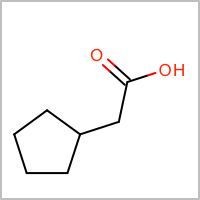

In [3]:
# Create empty OEMol
mol = oechem.OEMol()
# Convert SMILES
oechem.OESmilesToMol(mol, guest_smiles)
# Draw
oenb.draw_mol(mol)

# Get host file and prep it for docking
(Note that we are going to skip charge assignment for the purposes of this example, because it's slow. So you want to use an input file which has provided charges, OR add charge assignment.)

## Retrieve host file, do file bookkeeping

In [4]:
# Output host and guest files
hostfile = os.path.join(datadir, 'host.mol2')
guestfile = os.path.join(datadir, 'guest.mol2')

# Create data dir if not present
if not os.path.isdir(datadir):
    os.mkdir(datadir)

# Set host file name and retrieve file
if 'http' in host_source:
    import urllib
    urllib.request.urlretrieve(host_source, hostfile)
else:
    import shutil
    shutil.copy(host_source, hostfile)

## Prep host file for docking

Here we'll load the host and prepare for docking, which takes a bit of time as it has to get prepared as a "receptor" for docking into

In [5]:
# Read in host file
ifile = oechem.oemolistream(hostfile)
host = oechem.OEMol()
oechem.OEReadMolecule( ifile, host)
ifile.close()

# Prepare a receptor - Start by getting center of mass to use as a hint for where to dock
com = oechem.OEFloatArray(3)
oechem.OEGetCenterOfMass(host, com) 

# Create receptor, as per https://docs.eyesopen.com/toolkits/python/dockingtk/receptor.html#creating-a-receptor
receptor = oechem.OEGraphMol()
oedocking.OEMakeReceptor(receptor, host, com[0], com[1], com[2])

True

## Generate 3D structure of our guest and dock it

In [6]:
#initialize omega for conformer generation
omega = oeomega.OEOmega()
omega.SetMaxConfs(100) #Generate up to 100 conformers since we'll use for docking
omega.SetIncludeInput(False)
omega.SetStrictStereo(True) #Refuse to generate conformers if stereochemistry not provided

#Initialize charge generation
chargeEngine = oequacpac.OEAM1BCCCharges()

# Initialize docking
dock = oedocking.OEDock()
dock.Initialize(receptor)

# Build OEMol from SMILES
# Generate new OEMol and parse SMILES
mol = oechem.OEMol()
oechem.OEParseSmiles( mol, guest_smiles)
# Set to use a simple neutral pH model 
oequacpac.OESetNeutralpHModel(mol)

# Generate conformers with Omega; keep only best conformer
status = omega(mol)
if not status:
    print("Error generating conformers for %s." % (guest_smiles))
    #print(smi, name, mol.NumAtoms()) #Print debug info -- make sure we're getting protons added as we should

# Assign AM1-BCC charges
oequacpac.OEAssignCharges(mol, chargeEngine)

# Dock to host
dockedMol = oechem.OEGraphMol()
status = dock.DockMultiConformerMolecule(dockedMol, mol) #By default returns only top scoring pose
sdtag = oedocking.OEDockMethodGetName(oedocking.OEDockMethod_Chemgauss4)
oedocking.OESetSDScore(dockedMol, dock, sdtag)
dock.AnnotatePose(dockedMol)

# Write out docked pose if docking successful
if status == oedocking.OEDockingReturnCode_Success:
    outmol = dockedMol

    # Write out
    tripos_mol2_filename = os.path.join(os.path.join(datadir, 'docked_guest.mol2'))
    ofile = oechem.oemolostream( tripos_mol2_filename )
    oechem.OEWriteMolecule( ofile, outmol)
    ofile.close()

    # Clean up residue names in mol2 files that are tleap-incompatible: replace substructure names with valid text.
    infile = open( tripos_mol2_filename, 'r')
    lines = infile.readlines()
    infile.close()
    newlines = [line.replace('<0>', 'GUEST') for line in lines]
    outfile = open(tripos_mol2_filename, 'w')
    outfile.writelines(newlines)
    outfile.close()
else:
    raise Exception("Error: Docking failed.")

## Visualize in 3D to make sure we placed the guest into the binding site
This is optional, but very helpful to make sure you're starting off with your guest in the binding site. To execute this you'll need `nglview` for visualization and `mdtraj` for working with trajectory files

In [7]:
# Import modules
import nglview
import mdtraj

# Load host structure ("trajectory")
traj = mdtraj.load(os.path.join(datadir, 'host.mol2'))
# Load guest structure
lig = mdtraj.load(os.path.join(tripos_mol2_filename))
                  
# Figure out which atom indices correspond to the guest, for use in visualization
atoms_guest = [ traj.n_atoms+i for i in range(lig.n_atoms)]

# "Stack" host and guest Trajectory objects into a single object
complex = traj.stack(lig)

# Visualize
view = nglview.show_mdtraj(complex)
view.add_representation('spacefill', selection="all")
view.add_representation('spacefill', selection=atoms_guest, color='blue')  #Adjust guest to show as blue for contrast
# The view command needs to be the last command issued to nglview
view

//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py:1961: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py:1963: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


# Solvate complex

Next we're going to solvate the complex using PDBFixer -- a fairly basic tool, but one which should work. Before doing so, we need to combine the host and the guest into a single OEMol, and then in this case we'll write out a file containing this as a PDB for PDBFixer to read. However, we won't actually use the Topology from that PDB going forward, as the PDB will lose chemistry information we currently have in our OEMols (e.g. it can't retain charges, etc.). Instead, we'll obtain an OpenMM Topology by converting directly from OEChem using utility functionality in `oeommtools`, and we'll solvate THIS using PDBFixer.

In [8]:
# Join OEMols into complex
complex = host.CreateCopy()
oechem.OEAddMols( complex, outmol)

# Write out complex PDB file (won't really use it except as a template)
ostream = oechem.oemolostream( os.path.join(datadir, 'complex.pdb'))
oechem.OEWriteMolecule( ostream, complex)
ostream.close()

# Solvate the system using PDBFixer
# Loosely follows https://github.com/oess/openmm_orion/blob/master/ComplexPrepCubes/utils.py
fixer = PDBFixer( os.path.join(datadir, 'complex.pdb'))

# Convert between OpenEye and OpenMM Topology
omm_top, omm_pos = oeommutils.oemol_to_openmmTop(complex)

# Use correct topology, positions
fixer.topology = omm_top
fixer.positions = omm_pos

# Solvate in 20 mM NaCl and water
fixer.addSolvent(padding=unit.Quantity( 1.0, unit.nanometers), ionicStrength=unit.Quantity( 20, unit.millimolar))

# Note that the final Topology from PDBFixer does not retain bond orders (see link above); this is not 
# important for our purposes here, but would be relevant if this were being converted back to OpenEye molecules.

# Write file of solvated system for visualization purposes -- we don't expect to use it, but may be useful to visualize
PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(datadir, 'complex_solvated.pdb'), 'w'))

# Apply SMIRNOFF to set up the system for simulation with OpenMM

Next, we apply a SMIRNOFF force field (SMIRNOFF99Frosst) to the system to set it up for simulation with OpenMM (or writing out, via ParmEd, to formats for use in a variety of other simulation packages).

Prepping a system with SMIRNOFF takes basically three components:
- An OpenMM `Topology` for the system, which we have from above (coming out of PDBFixer)
- OEMol objects for the components of the system (here host, guest, water and ions)
- The force field XML files

Here, we do not yet have OEMol objects for the ions so our first step is to generate those, and combine it with the host and guest OEMols

## Build a list of OEMols of all our components

In [9]:
# Keep a list of OEMols of our components
oemols = [] 

# Build ions from SMILES strings
smiles = ['[Na+]', '[Cl-]']
for smi in smiles:
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, smi)
    # Make sure we have partial charges assigned for these (monatomic, so equal to formal charge)
    for atom in mol.GetAtoms():
        atom.SetPartialCharge(atom.GetFormalCharge())

    oemols.append(mol)

# Build water reference molecule
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, 'O')
oechem.OEAddExplicitHydrogens(mol)
oechem.OETriposAtomNames(mol)
oemols.append(mol)
    
# Add oemols of host and guest
oemols.append(host)
oemols.append(outmol)

## Load our force field and parameterize the system

This uses the SMIRNOFF ForceField class and SMIRNOFF XML files to parameterize the system.

In [10]:
# Load force fields for small molecules (plus default ions), water, and (temporarily) hydrogen bonds.
# TODO add HBonds constraint through createSystem when openforcefield#32 is implemented, alleviating need for constraints here
ff = ForceField('forcefield/smirnoff99Frosst.ffxml', 'hbonds.ffxml', 'forcefield/tip3p.ffxml') 

# Set up system
# This draws to some extent on Andrea Rizzi's code at https://github.com/MobleyLab/SMIRNOFF_paper_code/blob/master/scripts/create_input_files.py
system = ff.createSystem(fixer.topology, oemols, nonbondedMethod = PME, nonbondedCutoff=1.1*unit.nanometer, ewaldErrorTolerance=1e-4)  #, constraints=smirnoff.HBonds)
# TODO add HBonds constraints here when openforcefield#32 is implemented.

# Fix switching function.
# TODO remove this when openforcefield#31 is fixed
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        force.setUseSwitchingFunction(True)
        force.setSwitchingDistance(1.0*unit.nanometer)


# Minimize and (very briefly) simulate our system

Here we will do an energy minimization, followed by a very very brief simulation. These are done in separate cells since OpenMM is quite slow on CPUs so you may not want to run the simulation on your computer if you are using a CPU.

## Finalize prep and energy minimize


In [11]:
# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = app.Simulation(fixer.topology, system, integrator)
# Copy in the positions
simulation.context.setPositions( fixer.positions) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

Energy before minimization (kcal/mol): 9.4e+03
Energy after minimization (kcal/mol): -2.2e+03


## Run an MD simulation of a few steps, storing a trajectory for visualization

In [12]:
# Set up NetCDF reporter for storing trajectory; prep for Langevin dynamics
from mdtraj.reporters import NetCDFReporter
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

# Prep Simulation
simulation = app.Simulation(fixer.topology, system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
# Set up to write trajectory file to NetCDF file in data directory every 100 frames
netcdf_reporter = NetCDFReporter(os.path.join(datadir, 'trajectory.nc'), 100) #Store every 100 frames
# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(netcdf_reporter)
simulation.reporters.append(app.StateDataReporter(os.path.join(datadir, 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))

# Run the simulation and print start info; store timing
print("Starting simulation")
start = time.clock()
simulation.step(1000) #1000 steps of dynamics
end = time.clock()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds" % (end-start))
netcdf_reporter.close()
print("Done!")

Starting simulation
Elapsed time 3.54 seconds
Done!


In [13]:
# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
traj= mdtraj.load(os.path.join(datadir, 'trajectory.nc'), top=os.path.join(datadir, 'complex_solvated.pdb'))

#Recenter/impose periodicity to the system
anchor = traj.top.guess_anchor_molecules()[0]
imgd = traj.image_molecules(anchor_molecules=[anchor])
traj.center_coordinates()

# View the trajectory
view = nglview.show_mdtraj(traj)
# I haven't totally figured out nglview's selection language for our purposes here, so I'm just showing two residues
# which seems (in this case) to include the host and guest plus an ion (?). 
view.add_licorice('1-2')
view